In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset) # 68*32 = 2176  last batch is not of 32 size 

68

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 1 1 1 1 0 2 1 1 0 1 0 0 1 0 0 1 1 1 2 1 0 1 1 1 0 0 0]


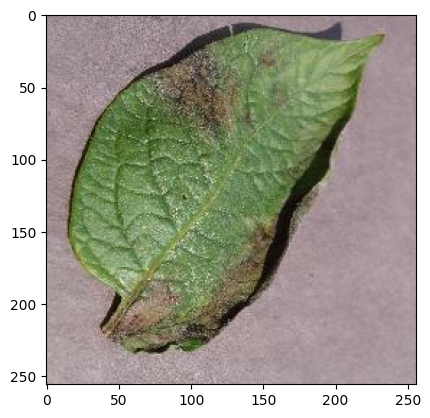

In [20]:
plt.imshow(image_batch[0].numpy().astype("uint8"))
# plt.axis("off")

2025-04-12 12:23:08.528644: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


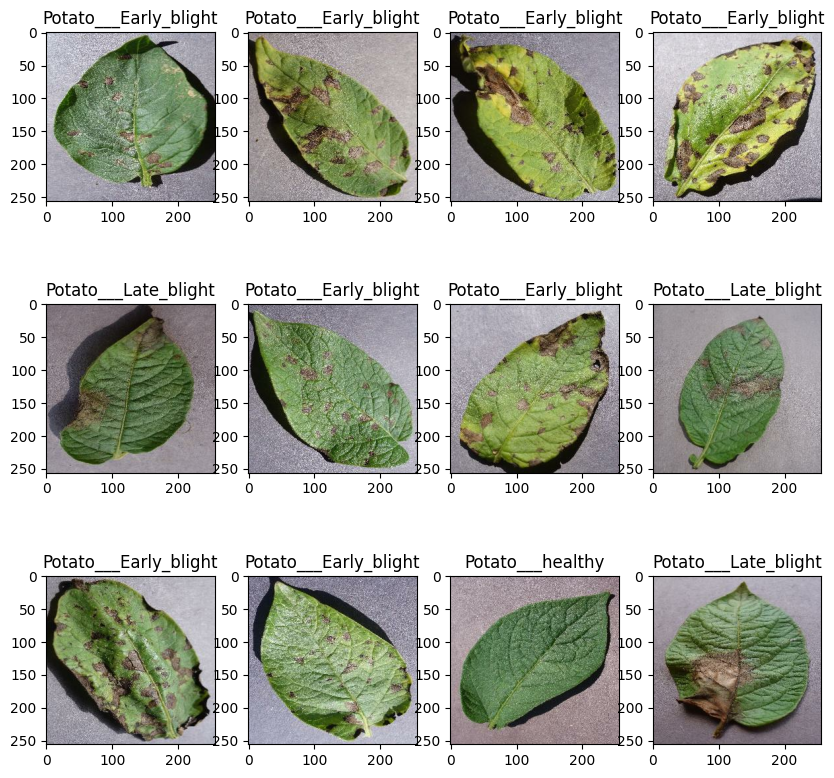

In [21]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])

In [23]:
len(dataset)

68

In [25]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [26]:
train_ds = dataset.take(54)
len(train_ds)

54

In [27]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [28]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [30]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [31]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [34]:
def split_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split+test_split+val_split)==1
    
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)
    
    train_ds=ds.take(train_size)    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [35]:
train_ds,val_ds,test_ds = split_dataset(dataset)

In [36]:
len(train_ds)

54

In [37]:
len(val_ds)

6

In [38]:
len(test_ds)

8

In [40]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
resize_and_rescale=tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

In [44]:
data_augmentation=tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [58]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    tf.keras.Input(shape=input_shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])




In [59]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [61]:
history = model.fit(
    train_ds,
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 421ms/step - accuracy: 0.4387 - loss: 0.9524 - val_accuracy: 0.6042 - val_loss: 0.9173
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 437ms/step - accuracy: 0.6325 - loss: 0.8146 - val_accuracy: 0.7865 - val_loss: 0.5066
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 460ms/step - accuracy: 0.7848 - loss: 0.5025 - val_accuracy: 0.8333 - val_loss: 0.4504
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - accuracy: 0.8760 - loss: 0.2930 - val_accuracy: 0.8594 - val_loss: 0.3552
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - accuracy: 0.8768 - loss: 0.3206 - val_accuracy: 0.9531 - val_loss: 0.1381
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - accuracy: 0.9230 - loss: 0.1839 - val_accuracy: 0.9271 - val_loss: 0.1840
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - accuracy: 0.9182 - loss: 0.2039 - val_accuracy: 0.9271 - val_loss: 0.1704
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 473ms/step - accuracy: 0.9548 - loss: 0.1121 - val_accu

In [67]:
performance = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9948 - loss: 0.0202


In [68]:
performance

[0.03264867141842842, 0.98828125]

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
predicted label: Potato___Early_blight


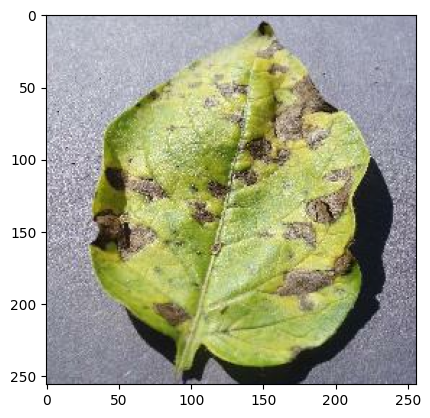

In [69]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [70]:
model.save("models/potato_disease_prediction_model.h5")
